# Import Library

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy import stats
from scipy.stats import norm,skew


from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

#warning
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)


# Import Data

In [3]:
df = pd.read_excel("Python/CarData.xlsx")

In [7]:
df.head(10)

,No,Mpg,Cylinders,Displacement,Power,Weight,Acceleration,Year,Origin,Model
0,1,18.00,8,307.00,130.00,3504,12.00,70,USA,Chevrolet Chevelle Malibu
1,2,15.00,8,350.00,165.00,3693,11.50,70,USA,Buick Skylark 320
2,3,18.00,8,318.00,150.00,3436,11.00,70,USA,Plymouth Satellite
3,4,16.00,8,304.00,150.00,3433,12.00,70,USA,Amc Rebel Sst
4,5,17.00,8,302.00,140.00,3449,10.50,70,USA,Ford Torino
5,6,15.00,8,429.00,198.00,4341,10.00,70,USA,Ford Galaxie 500
6,7,14.00,8,454.00,220.00,4354,9.00,70,USA,Chevrolet Impala
7,8,14.00,8,440.00,215.00,4312,8.50,70,USA,Plymouth Fury Iii
8,9,14.00,8,455.00,225.00,4425,10.00,70,USA,Pontiac Catalina
9,10,15.00,8,390.00,190.00,3850,8.50,70,USA,Amc Ambassador Dpl


In [4]:
df.shape

(398, 10)

In [6]:
df.dtypes

No                int64
Mpg             float64
Cylinders         int64
Displacement    float64
Power           float64
Weight            int64
Acceleration    float64
Year              int64
Origin           object
Model            object
dtype: object

In [8]:
df.describe([0,0.05,0.25,0.5,0.75,0.95,0.99,1]).T

,count,mean,std,min,0%,5%,25%,50%,75%,95%,99%,100%,max
No,398.00,199.50,115.04,1.00,1.00,20.85,100.25,199.50,298.75,378.15,394.03,398.00,398.00
Mpg,398.00,23.51,7.82,9.00,9.00,13.00,17.50,23.00,29.00,37.03,43.42,46.60,46.60
Cylinders,398.00,5.45,1.70,3.00,3.00,4.00,4.00,4.00,8.00,8.00,8.00,8.00,8.00
Displacement,398.00,193.43,104.27,68.00,68.00,85.00,104.25,148.50,262.00,400.00,440.42,455.00,455.00
Power,392.00,104.47,38.49,46.00,46.00,60.55,75.00,93.50,126.00,180.00,220.45,230.00,230.00
Weight,398.00,2970.42,846.84,1613.00,1613.00,1923.50,2223.75,2803.50,3608.00,4464.00,4951.03,5140.00,5140.00
Acceleration,398.00,15.57,2.76,8.00,8.00,11.29,13.83,15.50,17.18,20.41,22.24,24.80,24.80
Year,398.00,76.01,3.70,70.00,70.00,70.00,73.00,76.00,79.00,82.00,82.00,82.00,82.00


In [259]:
# MPG Feature -> Mean = 23.51  Median = 23 , positive skewness

# Missing Value

In [12]:
import missingno as msno

In [11]:
df.isnull().sum()

No              0
Mpg             0
Cylinders       0
Displacement    0
Power           6
Weight          0
Acceleration    0
Year            0
Origin          0
Model           0
dtype: int64

Text(0.5, 1.0, 'Car Data Missing Values Map')

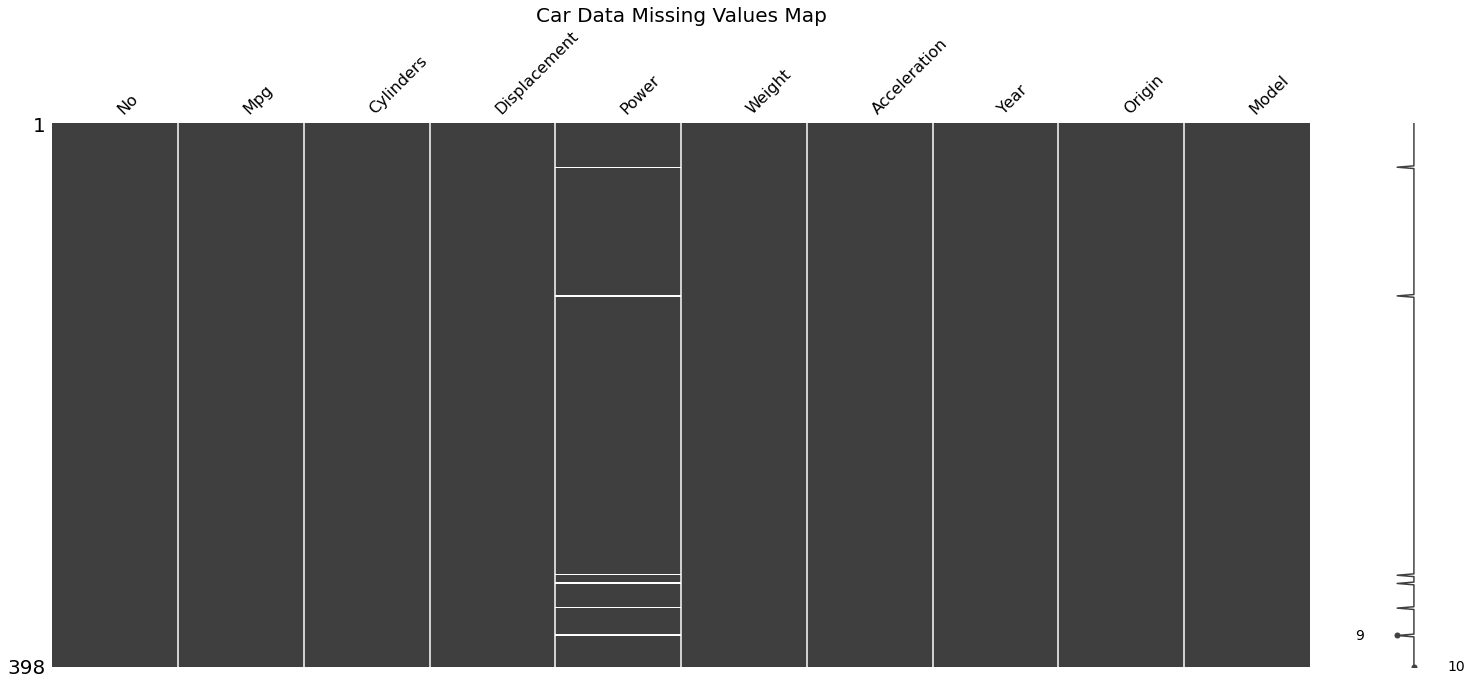

In [14]:
msno.matrix(df).set_title("Car Data Missing Values Map",fontsize=20)

# *Exploratory Data Analysis ( EDA )*


In [15]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen data framee.
    cat_th: int, float
    numerik fakat kategorik olan değişkenler için sınıf eşif değeri
    car_th: int, float
    kategorik fakat kardinal değişkenler için sınıf eşik değeri
    Returns
    -------
    cat_cols: list
        Lategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_card:
        Kategorik görünümlü kardinal değişken listesi
    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_card  cat_cols'un içinde
    Return olan 3 liste toplamı toplam değişken sayısına eşittir
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["category","object","bool"]]
    num_cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int64","int32","float64","float32"]
                    and dataframe[col].nunique() < cat_th]
    cat_cols += num_cat_cols

    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype in ["category","object"]
                   and dataframe[col].nunique() > car_th]

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int64","float64"]
                and dataframe[col].nunique() > cat_th]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_cat_cols: {len(num_cat_cols)}")

    return cat_cols,num_cols,cat_but_car


cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 398
Variables: 10
cat_cols: 2
num_cols: 7
cat_but_car: 1
num_cat_cols: 1


In [17]:
cat_cols

['Origin', 'Cylinders']

In [18]:
num_cols

['No', 'Mpg', 'Displacement', 'Power', 'Weight', 'Acceleration', 'Year']

In [21]:
cat_but_car

['Model']

In [22]:
df.head()

,No,Mpg,Cylinders,Displacement,Power,Weight,Acceleration,Year,Origin,Model
0,1,18.00,8,307.00,130.00,3504,12.00,70,USA,Chevrolet Chevelle Malibu
1,2,15.00,8,350.00,165.00,3693,11.50,70,USA,Buick Skylark 320
2,3,18.00,8,318.00,150.00,3436,11.00,70,USA,Plymouth Satellite
3,4,16.00,8,304.00,150.00,3433,12.00,70,USA,Amc Rebel Sst
4,5,17.00,8,302.00,140.00,3449,10.50,70,USA,Ford Torino


### Visualization categorical variables

   Cylinders  Ratio
4        204  51.26
8        103  25.88
6         84  21.11
3          4   1.01
5          3   0.75
###################################


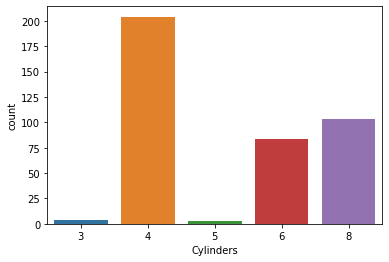

        Origin  Ratio
USA        249  62.56
Japan       79  19.85
Europe      70  17.59
###################################


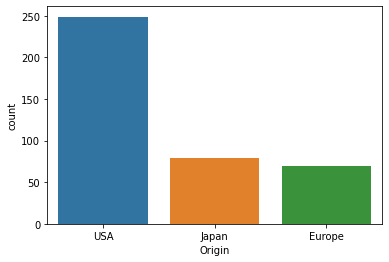

In [16]:
def cat_summary(dataframe, col_name,plot=False):
    if dataframe[col_name].dtype == 'bool':
        dataframe[col_name] = dataframe[col_name].astype(int)

    print(pd.DataFrame({col_name:df[col_name].value_counts(),
                        "Ratio":100*df[col_name].value_counts()/len(dataframe)}))
    print("###################################")

    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)

cat_summary(df,"Cylinders",plot=True)
cat_summary(df,"Origin",plot=True)

### Visualization numeric variables

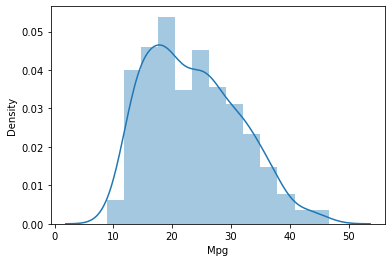

In [25]:
sns.distplot(df.Mpg)
plt.show()

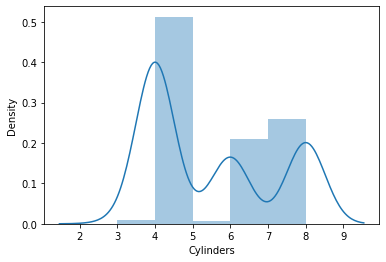

In [26]:
sns.distplot(df.Cylinders)
plt.show()


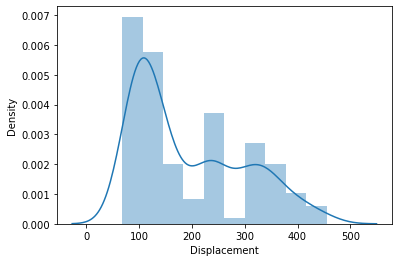

In [27]:
sns.distplot(df.Displacement)
plt.show()


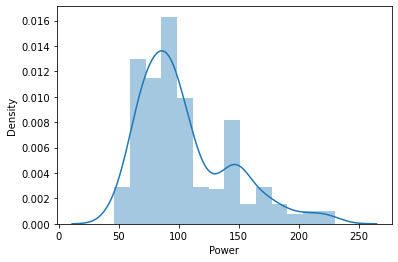

In [29]:
sns.distplot(df.Power)
plt.show()

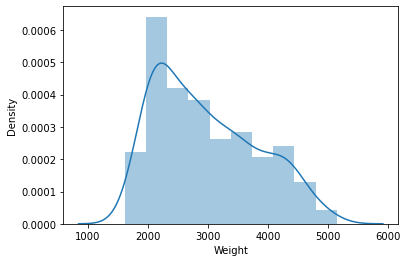

In [30]:
sns.distplot(df.Weight)
plt.show()

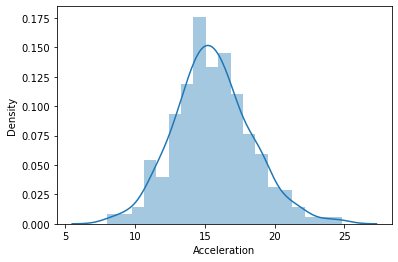

In [31]:
sns.distplot(df.Acceleration)
plt.show()

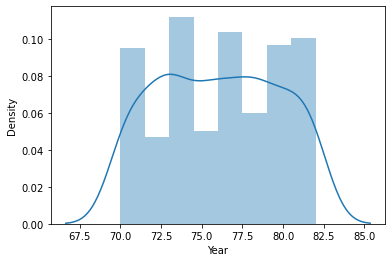

In [33]:
sns.distplot(df["Year"])
plt.show()


### The relationship of the dependent variable with other variables


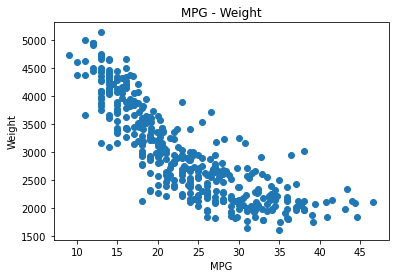

In [36]:
plt.scatter(df.Mpg,df.Weight)
plt.title("MPG - Weight")
plt.xlabel('MPG')
plt.ylabel('Weight')
plt.show()

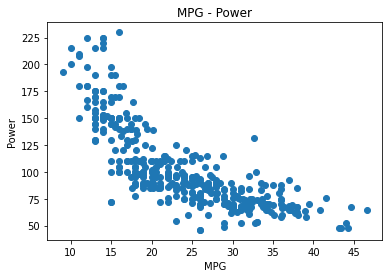

In [39]:
plt.scatter(df.Mpg,df.Power)
plt.title("MPG - Power")
plt.xlabel('MPG')
plt.ylabel('Power')
plt.show()

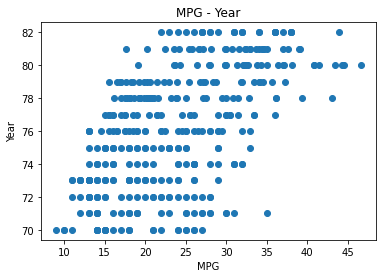

In [54]:
plt.scatter(df.Mpg,df.Year)
plt.title("MPG - Year")
plt.xlabel('MPG')
plt.ylabel('Year')
plt.show()

<AxesSubplot:>

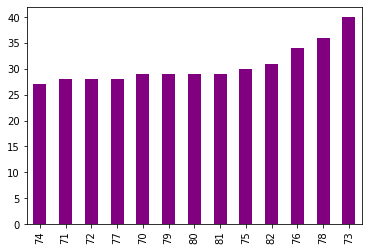

In [55]:
df['Year'].value_counts().sort_values().plot(kind = 'bar', color = 'purple')


# Fixing Missing Value Problem

In [40]:
df.isnull().sum()

No              0
Mpg             0
Cylinders       0
Displacement    0
Power           6
Weight          0
Acceleration    0
Year            0
Origin          0
Model           0
dtype: int64

In [41]:
df.describe()

,No,Mpg,Cylinders,Displacement,Power,Weight,Acceleration,Year
count,398.00,398.00,398.00,398.00,392.00,398.00,398.00,398.00
mean,199.50,23.51,5.45,193.43,104.47,2970.42,15.57,76.01
std,115.04,7.82,1.70,104.27,38.49,846.84,2.76,3.70
min,1.00,9.00,3.00,68.00,46.00,1613.00,8.00,70.00
25%,100.25,17.50,4.00,104.25,75.00,2223.75,13.83,73.00
50%,199.50,23.00,4.00,148.50,93.50,2803.50,15.50,76.00
75%,298.75,29.00,8.00,262.00,126.00,3608.00,17.18,79.00
max,398.00,46.60,8.00,455.00,230.00,5140.00,24.80,82.00


In [42]:
df["Power"] = df["Power"].fillna(df["Power"].mean())

In [43]:
df.isnull().sum()

No              0
Mpg             0
Cylinders       0
Displacement    0
Power           0
Weight          0
Acceleration    0
Year            0
Origin          0
Model           0
dtype: int64

# *CORR MATRIX*

In [48]:
df.head()

,No,Mpg,Cylinders,Displacement,Power,Weight,Acceleration,Year,Origin,Model
0,1,18.00,8,307.00,130.00,3504,12.00,70,USA,Chevrolet Chevelle Malibu
1,2,15.00,8,350.00,165.00,3693,11.50,70,USA,Buick Skylark 320
2,3,18.00,8,318.00,150.00,3436,11.00,70,USA,Plymouth Satellite
3,4,16.00,8,304.00,150.00,3433,12.00,70,USA,Amc Rebel Sst
4,5,17.00,8,302.00,140.00,3449,10.50,70,USA,Ford Torino


In [46]:
df["Model"].value_counts()

Ford Pinto             6
Toyota Corolla         5
Amc Matador            5
Ford Maverick          5
Chevrolet Chevette     4
                      ..
Chevrolet Monza 2+2    1
Ford Mustang Ii        1
Pontiac Astro          1
Amc Pacer              1
Chevy S-10             1
Name: Model, Length: 305, dtype: int64

In [50]:
removed_columns = ["No","Model"]

In [51]:
df.drop(removed_columns,
        axis=1,
        inplace = True)

In [52]:
df.head()

,Mpg,Cylinders,Displacement,Power,Weight,Acceleration,Year,Origin
0,18.00,8,307.00,130.00,3504,12.00,70,USA
1,15.00,8,350.00,165.00,3693,11.50,70,USA
2,18.00,8,318.00,150.00,3436,11.00,70,USA
3,16.00,8,304.00,150.00,3433,12.00,70,USA
4,17.00,8,302.00,140.00,3449,10.50,70,USA


In [59]:
df = df.replace("USA",1)
df = df.replace("Japan",2)
df = df.replace("Europe",3)

In [60]:
df.head()

,Mpg,Cylinders,Displacement,Power,Weight,Acceleration,Year,Origin
0,18.00,8,307.00,130.00,3504,12.00,70,1
1,15.00,8,350.00,165.00,3693,11.50,70,1
2,18.00,8,318.00,150.00,3436,11.00,70,1
3,16.00,8,304.00,150.00,3433,12.00,70,1
4,17.00,8,302.00,140.00,3449,10.50,70,1


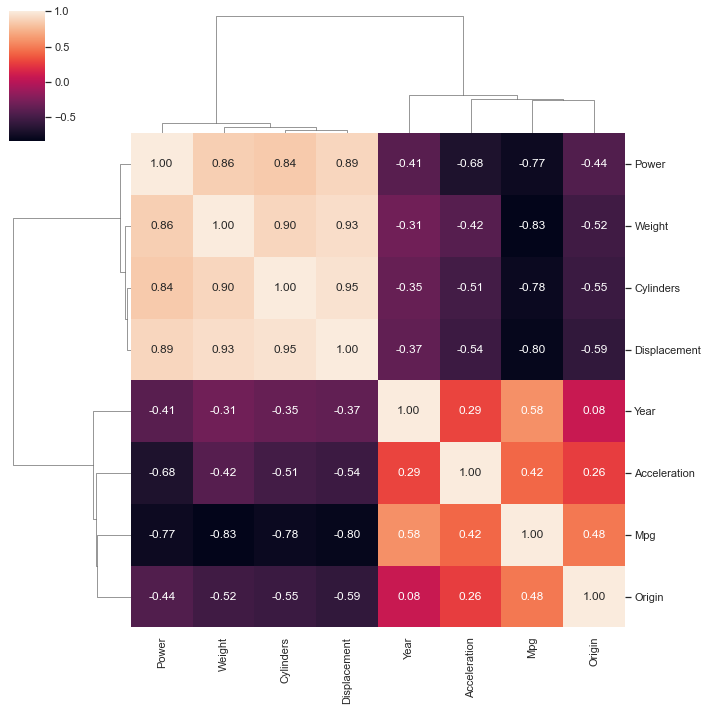

In [61]:
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot=True, fmt = ".2f")
plt.show()

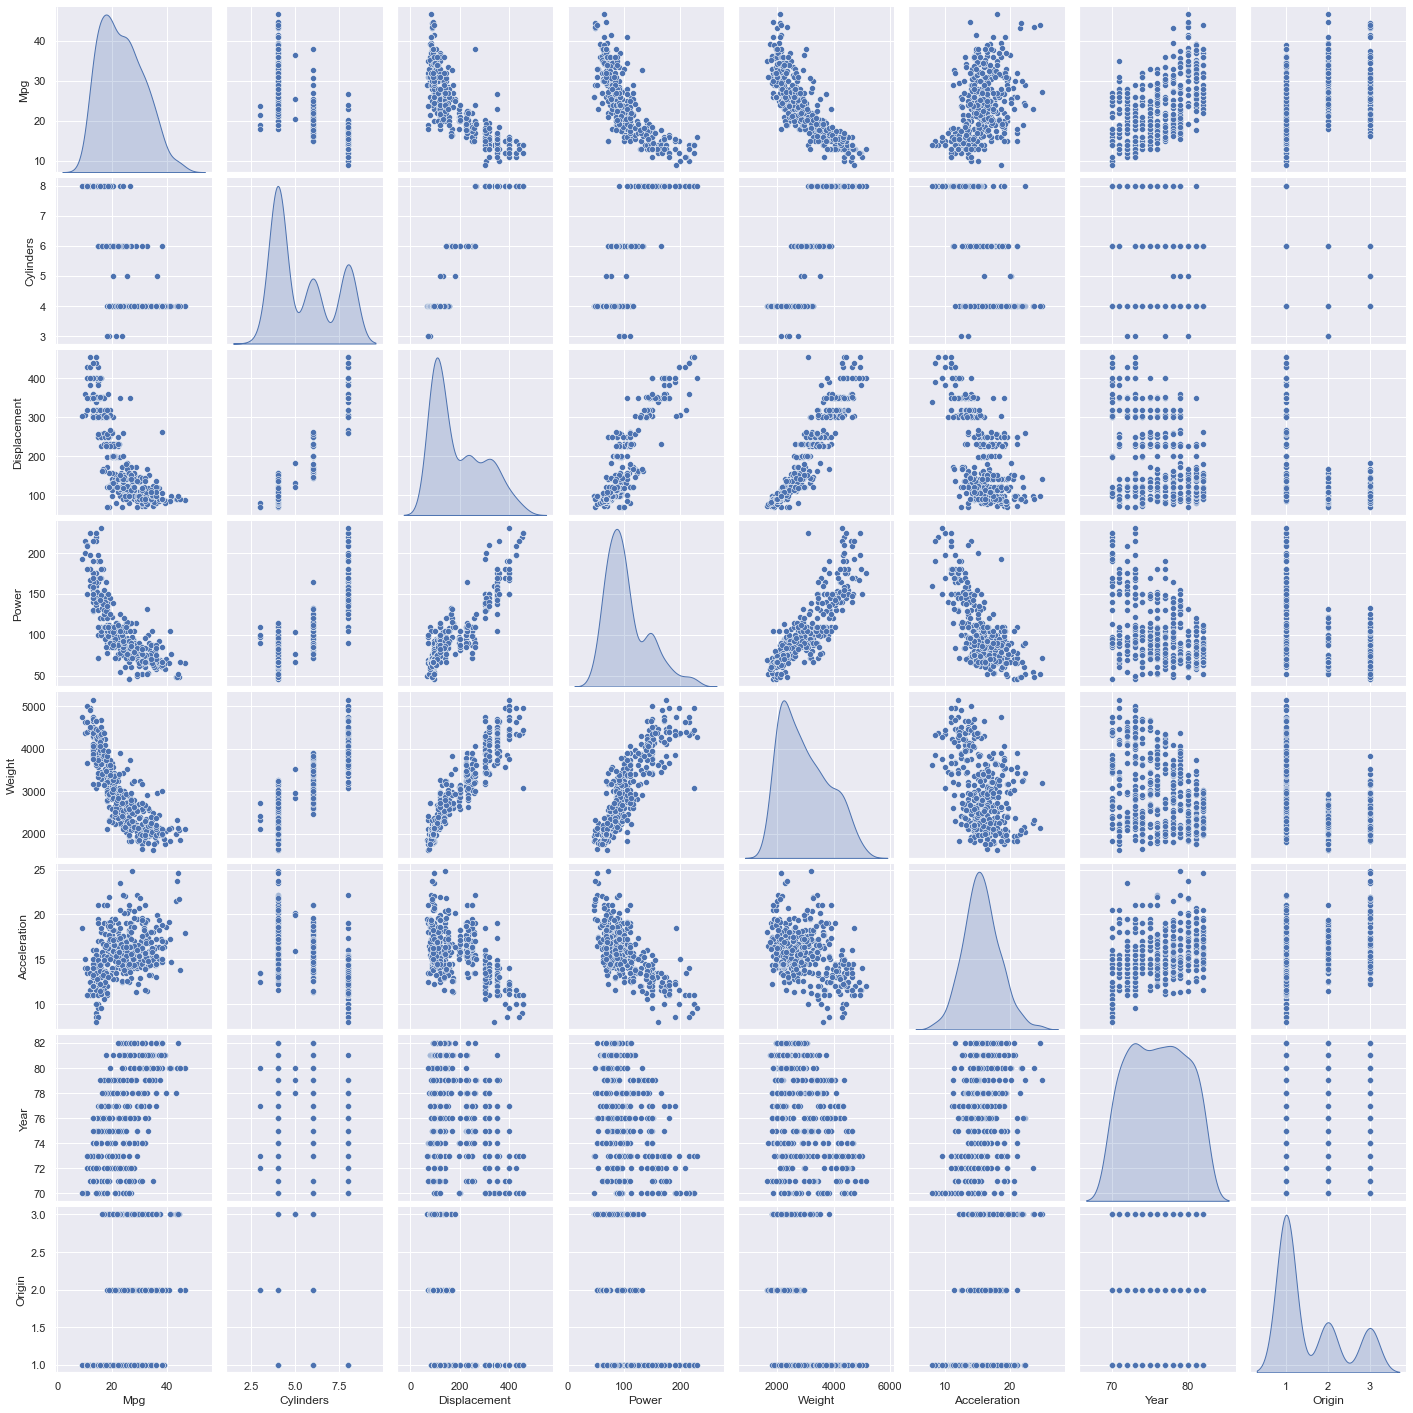

In [62]:
sns.pairplot(df, diag_kind="kde")
plt.show()

# BOXPLOT

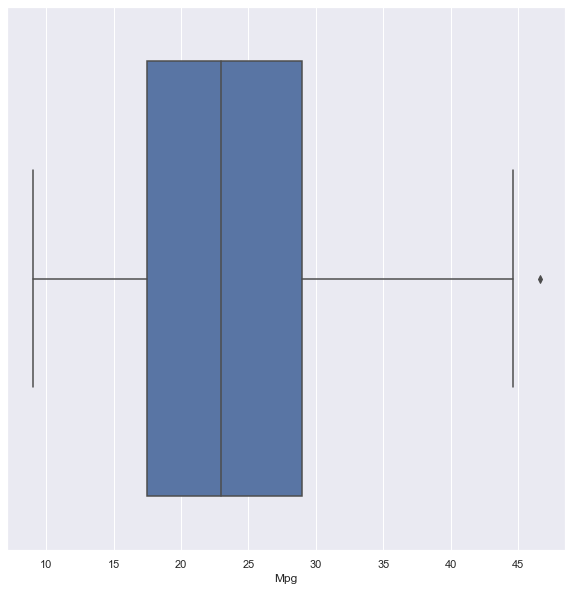

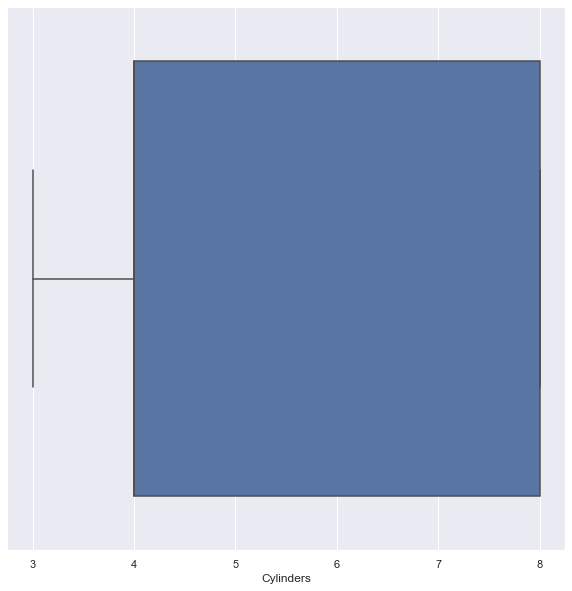

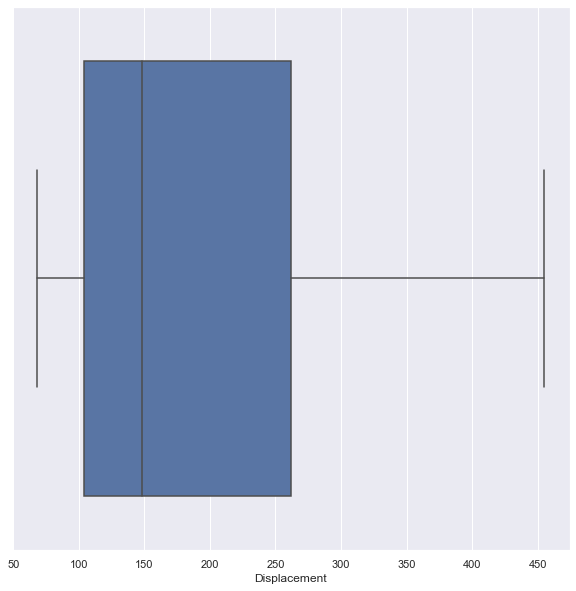

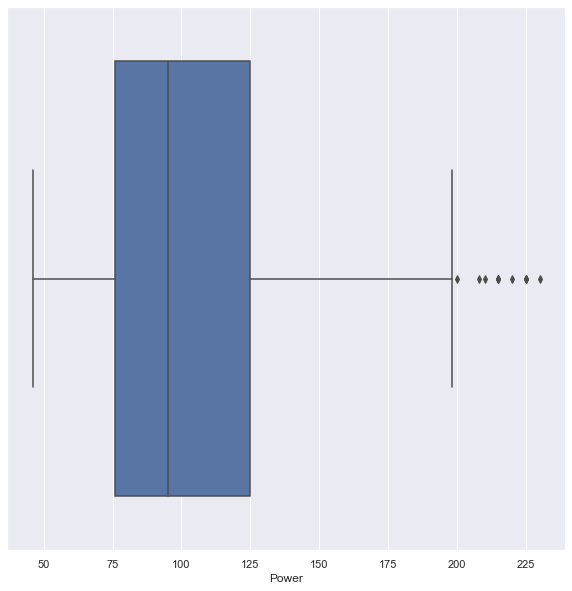

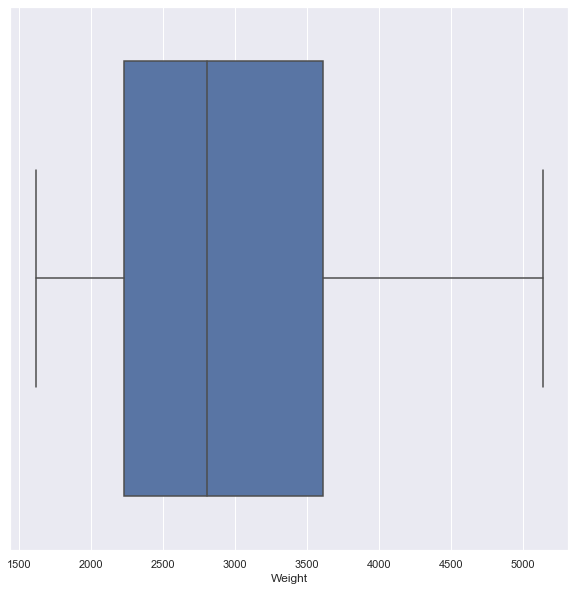

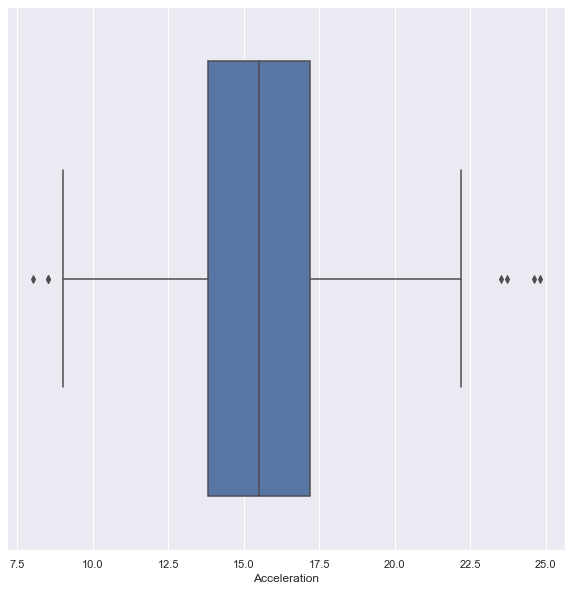

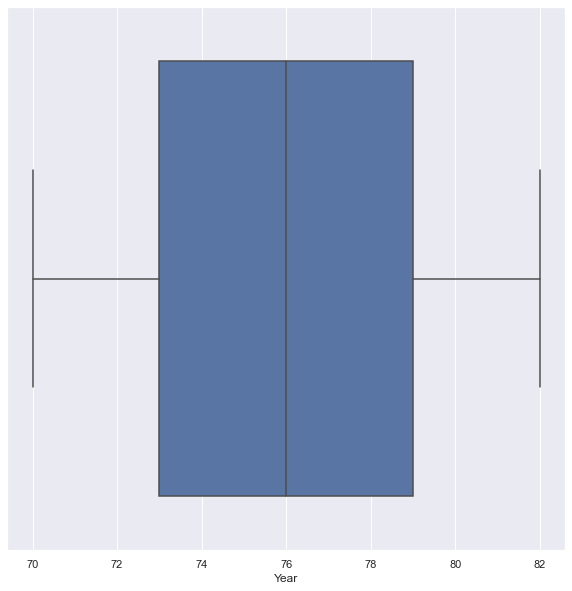

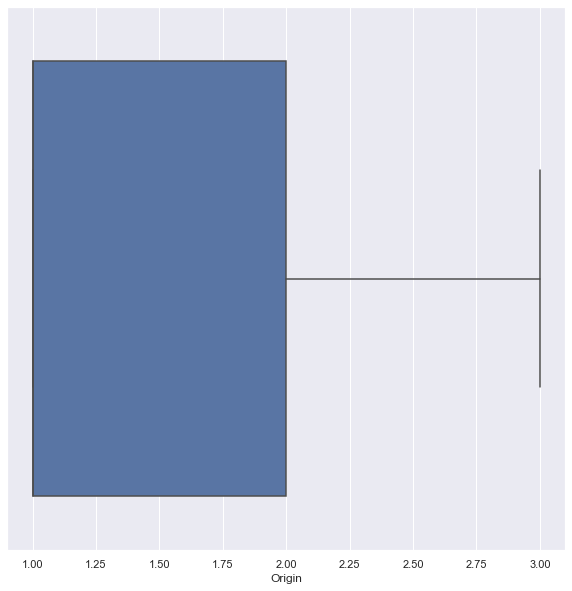

In [63]:
for i in df.columns:
    plt.figure()
    sns.boxplot(x = i , data = df,)
    plt.show()

## *Normality Test*

In [77]:
from scipy.stats import shapiro

In [78]:
shapiro(df)

ShapiroResult(statistic=0.46005934476852417, pvalue=0.0)

# Outlier Detection

In [79]:
# Threshold setting function
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    low_limit = quartile1 - 1.5*iqr
    up_limit = quartile3 + 1.5*iqr
    return low_limit,up_limit

In [80]:
# Is there an outlier or not?
def check_outlier(dataframe,col_name):
    low,up = outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name] < low) | (dataframe[col_name]>up)].any(axis=None):
        return True
    else:
        return False

In [95]:
## Looped version of above codes
for col in df.columns:
    print(col,":",check_outlier(df,col))

Mpg : True
Cylinders : False
Displacement : False
Power : True
Weight : False
Acceleration : True
Year : False
Origin : False


In [96]:
# Which observations outlier ?
def grab_outliers(dataframe,col,index=False):
    low,up = outlier_thresholds(dataframe,col)
    if not dataframe[(dataframe[col] < low) | (dataframe[col] > up)].any(axis=None):
        print("There is no outlier")
        return 0
    if dataframe[(dataframe[col] < low) | (dataframe[col] > up)].shape[0] > 10:
        print(dataframe[(dataframe[col] < low) | (dataframe[col] > up)].head())
    else:
        print(dataframe[(dataframe[col] < low) | (dataframe[col] > up)])
    if index:
        return dataframe[(dataframe[col] < low) | (dataframe[col] > up)].index

In [97]:
grab_outliers(df,"Mpg")


      Mpg  Cylinders  Displacement  Power  Weight  Acceleration  Year  Origin
322 46.60          4         86.00  65.00    2110         17.90    80       2


In [98]:
grab_outliers(df,"Power")

     Mpg  Cylinders  Displacement  Power  Weight  Acceleration  Year  Origin
6  14.00          8        454.00 220.00    4354          9.00    70       1
7  14.00          8        440.00 215.00    4312          8.50    70       1
8  14.00          8        455.00 225.00    4425         10.00    70       1
13 14.00          8        455.00 225.00    3086         10.00    70       1
25 10.00          8        360.00 215.00    4615         14.00    70       1


In [99]:
grab_outliers(df,"Acceleration")

      Mpg  Cylinders  Displacement  Power  Weight  Acceleration  Year  Origin
7   14.00          8        440.00 215.00    4312          8.50    70       1
9   15.00          8        390.00 190.00    3850          8.50    70       1
11  14.00          8        340.00 160.00    3609          8.00    70       1
59  23.00          4         97.00  54.00    2254         23.50    72       3
299 27.20          4        141.00  71.00    3190         24.80    79       3
326 43.40          4         90.00  48.00    2335         23.70    80       3
394 44.00          4         97.00  52.00    2130         24.60    82       3


In [101]:
# Removing outliers
def remove_outlier(dataframe,col):
    low,up = outlier_thresholds(dataframe,col)
    df_without_outliers = dataframe[~((df[col] < low) | (df[col]>up))]
    return df_without_outliers

In [102]:
df = remove_outlier(df,"Mpg")           # Remove MPG outliers

In [103]:
df = remove_outlier(df,"Power")    # Remove Horepower outliers

In [104]:
df = remove_outlier(df,"Acceleration")  # Remove Acceleration outliers

In [105]:
df.shape

(378, 8)

In [106]:
shapiro(df)

ShapiroResult(statistic=0.4596598148345947, pvalue=0.0)

# *Feature Engineering*

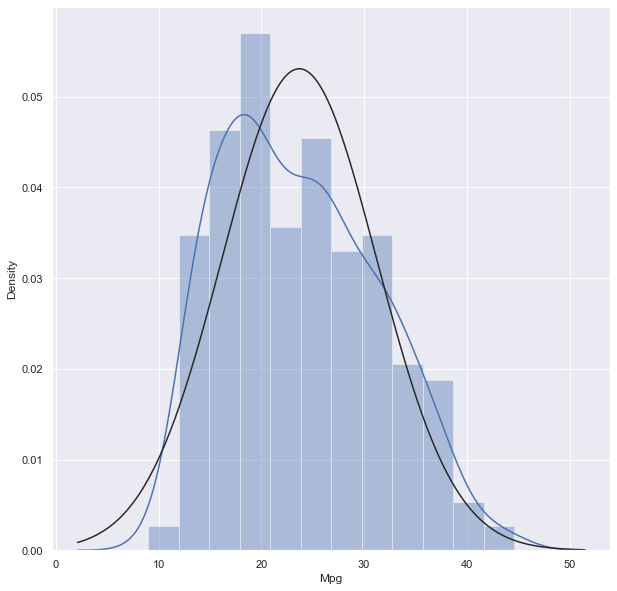

m: 23.68703703703704, sigma: 7.5147063014844475


In [108]:
## Target Feature = MPG

sns.distplot(df.Mpg, fit=norm)
plt.show()

(m,sigma) = norm.fit(df["Mpg"])
print("m: {}, sigma: {}".format(m,sigma))


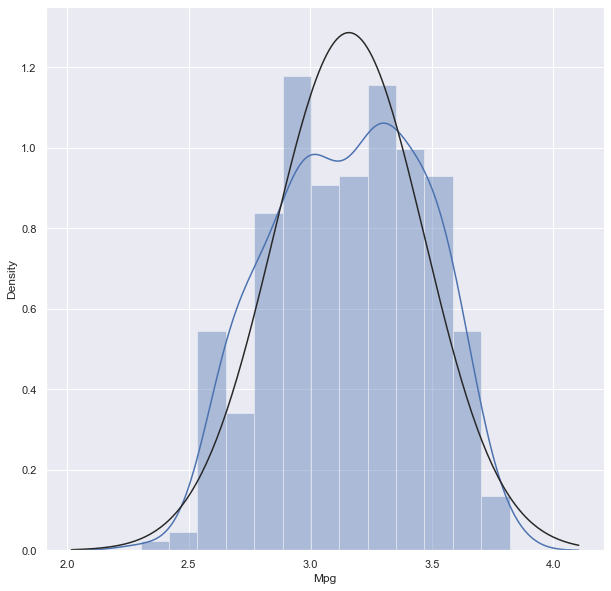

In [110]:
# MPG -> log transformation for skewness

df["Mpg"] = np.log1p(df["Mpg"])
sns.distplot(df.Mpg, fit=norm)
plt.show()

## *One Hot Encoding*

In [120]:
df.Cylinders = df.Cylinders.astype(str)
df.Origin = df.Origin.astype(str)

In [121]:
df.head()

,Mpg,Cylinders,Displacement,Power,Weight,Acceleration,Year,Origin
0,2.94,8,307.00,130.00,3504,12.00,70,1
1,2.77,8,350.00,165.00,3693,11.50,70,1
2,2.94,8,318.00,150.00,3436,11.00,70,1
3,2.83,8,304.00,150.00,3433,12.00,70,1
4,2.89,8,302.00,140.00,3449,10.50,70,1


In [122]:
df = pd.get_dummies(df)

In [123]:
df.head()

,Mpg,Displacement,Power,Weight,Acceleration,Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.94,307.00,130.00,3504,12.00,70,0,0,0,0,1,1,0,0
1,2.77,350.00,165.00,3693,11.50,70,0,0,0,0,1,1,0,0
2,2.94,318.00,150.00,3436,11.00,70,0,0,0,0,1,1,0,0
3,2.83,304.00,150.00,3433,12.00,70,0,0,0,0,1,1,0,0
4,2.89,302.00,140.00,3449,10.50,70,0,0,0,0,1,1,0,0


# Train , Test

In [126]:
x = df.drop(["Mpg"],axis=1)
y = df["Mpg"]

In [131]:
x.head()

,Displacement,Power,Weight,Acceleration,Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,307.00,130.00,3504,12.00,70,0,0,0,0,1,1,0,0
1,350.00,165.00,3693,11.50,70,0,0,0,0,1,1,0,0
2,318.00,150.00,3436,11.00,70,0,0,0,0,1,1,0,0
3,304.00,150.00,3433,12.00,70,0,0,0,0,1,1,0,0
4,302.00,140.00,3449,10.50,70,0,0,0,0,1,1,0,0


In [129]:
y

0     2.94
1     2.77
2     2.94
3     2.83
4     2.89
      ... 
392   3.33
393   3.33
395   3.50
396   3.37
397   3.47
Name: Mpg, Length: 378, dtype: float64

In [132]:
test_size=0.3

In [190]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)

In [191]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Setting up All LazyRegressor Models

In [145]:
from lazypredict.Supervised import LazyRegressor

In [142]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

100%|██████████| 42/42 [00:03<00:00, 11.04it/s]


In [143]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.87,0.89,0.10,0.26
BaggingRegressor,0.87,0.89,0.10,0.07
HistGradientBoostingRegressor,0.87,0.89,0.10,0.38
ExtraTreesRegressor,0.87,0.89,0.10,0.20
OrthogonalMatchingPursuitCV,0.86,0.88,0.10,0.02
TransformedTargetRegressor,0.86,0.88,0.10,0.01
LinearRegression,0.86,0.88,0.10,0.01
LassoLarsIC,0.86,0.88,0.10,0.03
Ridge,0.86,0.88,0.10,0.01


# Linear Regression

In [146]:
linear_regression_model = LinearRegression().fit(x_train,y_train)

In [147]:
linear_regression_model.intercept_ # b0

3.156645306791795

In [151]:
linear_regression_model.coef_ # b1,b2...

array([ 0.02738273, -0.07636366, -0.15958824, -0.01383725,  0.0918176 ,
       -0.02536477,  0.03077458,  0.00756226, -0.01917094, -0.01126833,
       -0.01708023,  0.01781434,  0.0027549 ])

### Prediction

In [152]:
y_pred = linear_regression_model.predict(x_test)

In [161]:
y_pred

array([2.84217625, 2.96069856, 3.3611321 , 3.02056596, 2.9303756 ,
       3.12909302, 3.50079125, 3.17789236, 3.00658299, 2.70279096,
       3.48864655, 3.2964408 , 2.69199749, 2.74764804, 3.38270454,
       3.52541995, 3.33345869, 3.46856536, 2.95180303, 3.61033651,
       3.06291464, 2.96557891, 3.43368695, 3.45447821, 3.08481054,
       3.09356851, 2.9913704 , 3.35336234, 3.45470105, 3.43600159,
       2.89349552, 3.5079961 , 3.56522666, 3.02334795, 2.87502467,
       3.24734113, 3.10668769, 3.41529467, 3.43031433, 2.73693901,
       3.24033953, 3.40474081, 3.25751054, 3.62964319, 2.7504983 ,
       3.3242063 , 2.85183249, 3.37895617, 3.420088  , 3.23080733,
       2.87607007, 3.22524599, 3.28817632, 3.29397206, 2.82398788,
       3.22498455, 2.98969269, 3.25118635, 3.40330803, 2.76409237,
       3.35533162, 2.96385815, 3.11838621, 3.03189863, 2.69559874,
       3.47050087, 2.96530461, 3.13462541, 2.82983789, 2.59913579,
       3.33337397, 3.2350723 , 2.69108796, 3.10461193, 3.43035

### Error Values

In [162]:
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)

In [163]:
mse,rmse,mae

(0.010928854267320862, 0.10454116063695133, 0.07930078393375399)

In [166]:
linear_regression_model.score(x_test,y_test)

0.878074478112982

## Different Library With Linear Regression

In [173]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [170]:
reg_model = sm.OLS(y_train, x_train).fit()

In [177]:
vif = [variance_inflation_factor(pd.DataFrame(x_train).values, i)
       for i in range(len(pd.DataFrame(x_train).columns))]

In [179]:
pd.DataFrame(vif)

,0
0,25.53
1,11.36
2,14.31
3,2.95
4,1.28
5,inf
6,inf
7,inf
8,inf
9,inf


In [192]:
x_train = np.delete(x_train, 0, axis=1)

In [193]:
x_test = np.delete(x_test, 0, axis=1)

In [194]:
reg_model_2 = sm.OLS(y_train, x_train).fit()

In [195]:
vif = [variance_inflation_factor(pd.DataFrame(x_train).values, i)
       for i in range(len(pd.DataFrame(x_train).columns))]

In [196]:
vif

[11.31217359473347,
 10.46979893048672,
 2.816667313160024,
 1.2393939252340396,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [199]:
linear_regression_model_2 = LinearRegression().fit(x_train,y_train)

In [203]:
linear_regression_model_2.score(x_test,y_test)

0.8780474791629256

# Ridge Regression

In [209]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)

In [210]:
ridge = Ridge(random_state = 35 , max_iter=10000)

In [211]:
alphas = np.logspace(-4,-0.5,30)
tuned_parameters = [{"alpha":alphas}]
n_folds = 5
ridge_model = GridSearchCV(ridge,
                   tuned_parameters,
                   cv = n_folds,
                   scoring="neg_mean_squared_error",
                   refit=True)


In [212]:
ridge_model.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(max_iter=10000, random_state=35),
             param_grid=[{'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01])}],
             scoring='neg_mean_squared_error')

In [213]:
scores = ridge_model.cv_results_["mean_test_score"]

In [214]:
scores_std = ridge_model.cv_results_["std_test_score"]

In [215]:
print("Ridge Coef:",ridge_model.best_estimator_.coef_)
print("-----------------------------------------------")
print("Ridge Best Estimator:",ridge_model.best_estimator_)


Ridge Coef: [ 0.00030566 -0.00221524 -0.00019146 -0.00517968  0.02530233 -0.16631206
  0.08575607  0.10882703 -0.02391919 -0.00435184 -0.04112421  0.03754553
  0.00357868]
-----------------------------------------------
Ridge Best Estimator: Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=35)


In [216]:
y_pred = ridge_model.predict(x_test)

In [217]:
mse = mean_squared_error(y_test,y_pred)

In [219]:
print("Ridge MSE:",mse)

Ridge MSE: 0.010912378812359862


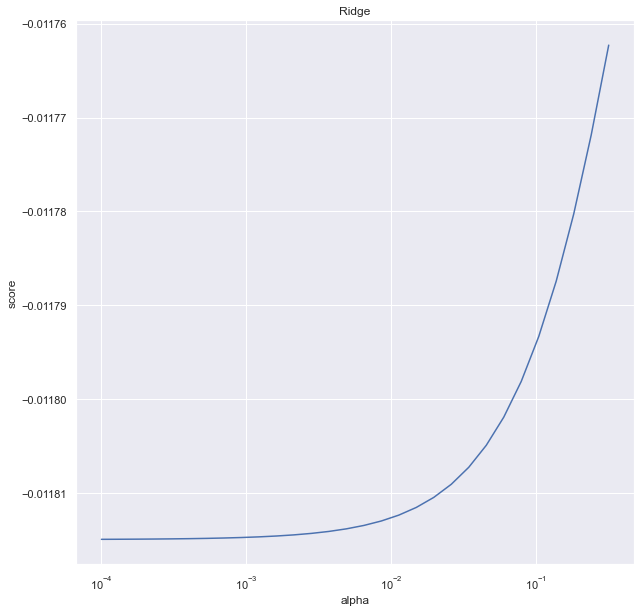

In [220]:
plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")
plt.show()

## Lasso Regression


In [231]:
lasso = Lasso(random_state=35 , max_iter=10000)
alphas = np.logspace(-4,-0.5,30)

tuned_parameters=[{"alpha":alphas}]
n_folds=5

lasso_model = GridSearchCV(lasso,
                   tuned_parameters,
                   cv=n_folds,
                   scoring="neg_mean_squared_error",
                   refit=True)

In [232]:
lasso_model.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, random_state=35),
             param_grid=[{'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01])}],
             scoring='neg_mean_squared_error')

In [233]:
print("Lasso Coef:",lasso_model.best_estimator_.coef_)
# Lasso assigns 0 to unnecessary features
print("-----------------------------------------------")
print("Lasso Best Estimator:",lasso_model.best_estimator_)

Lasso Coef: [ 0.00029976 -0.00222081 -0.00019248 -0.00464268  0.02540195 -0.14902287
  0.08446728  0.03371439 -0.02165347  0.         -0.04640649  0.02877058
  0.        ]
-----------------------------------------------
Lasso Best Estimator: Lasso(alpha=0.0004012807031942776, max_iter=10000, random_state=35)


In [234]:
y_pred = lasso_model.predict(x_test)

In [235]:
mse = mean_squared_error(y_test,y_pred)

In [236]:
print("Lasso MSE:",mse)

Lasso MSE: 0.010985250091280941


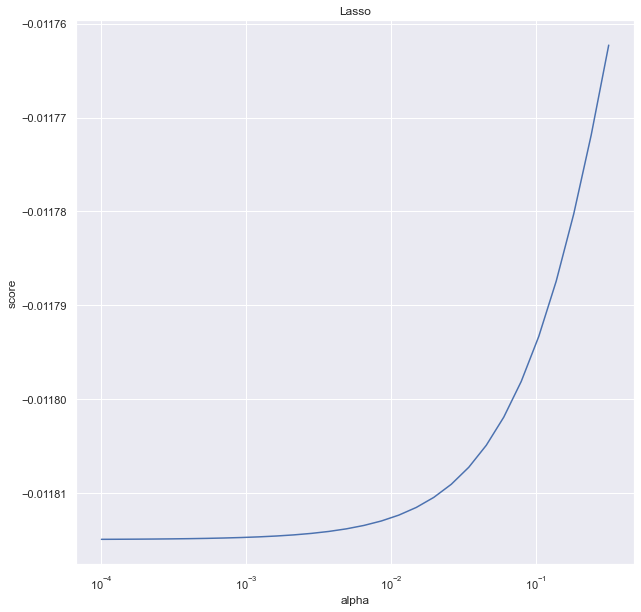

In [237]:
plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")
plt.show()

# ElasticNet

In [238]:
elasticnet = ElasticNet(random_state=35 , max_iter=10000)

alphas = np.logspace(-4,-0.5,30)
l1_ratio = np.arange(0,1,0.05)


parametersGrid = {"alpha":alphas,
                  "l1_ratio":l1_ratio}

n_folds=5

In [239]:
elasticnet_model = GridSearchCV(elasticnet,
                                parametersGrid,
                                cv=n_folds,
                                scoring="neg_mean_squared_error",
                                refit=True)


In [240]:
elasticnet_model.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000, random_state=35),
             param_grid={'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='neg_mean_squared_error')

In [241]:
scores = elasticnet_model.cv_results_["mean_test_score"]
scores_std = lasso_model.cv_results_["std_test_score"]

In [242]:
print("ElasticNet Coef:",elasticnet_model.best_estimator_.coef_)
print("-----------------------------------------------")
print("ElasticNet Best Estimator:",elasticnet_model.best_estimator_)


ElasticNet Coef: [ 0.00035662 -0.00223155 -0.00019507 -0.00423115  0.02550262 -0.1141213
  0.09026025  0.02351153 -0.01874097  0.         -0.04741519  0.0261477
  0.        ]
-----------------------------------------------
ElasticNet Best Estimator: ElasticNet(alpha=0.0037065129109221566, l1_ratio=0.1, max_iter=10000,
           random_state=35)


In [243]:
y_pred = elasticnet_model.predict(x_test)
mse = mean_squared_error(y_test,y_pred)

print("ElasticNet MSE:",mse)


ElasticNet MSE: 0.011037271033673704


# XGBoost

In [247]:
import xgboost as xgb
from xgboost import XGBRegressor

In [248]:
xgb= xgb.XGBRegressor()

In [249]:
parametersGrid = {"nthread":[4],
                  "objective":["reg:linear"],
                  "learning_rate":[0.03,0.05,0.07],
                  "max_depth":[5,6,7],
                  "min_child_weight":[4],
                  "subsample":[0.7],
                  "colsample_bytree":[0.7],
                  "n_estimators":[500,1000]}


In [251]:
xgboost_model = GridSearchCV(xgb,
                             parametersGrid,
                             cv=n_folds,
                             scoring="neg_mean_squared_error",
                             refit=True,
                             n_jobs=5)

In [252]:
xgboost_model.fit(x_train,y_train)

[03:05:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'colsample_by

In [253]:
y_pred = xgboost_model.predict(x_test)
mse = mean_squared_error(y_test,y_pred)

In [254]:
print("XGBRegressor MSE:" , mse)

XGBRegressor MSE: 0.010229163469911332


# Averaging Models

In [255]:
class AveragingModels():
    def __init__(self,models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self,x,y):
        self.models_ = [clone(x) for x in self.models]

        # train cloned base models
        for model in self.models_:
            model.fit(x,y)

        return self
    # now we do the predictions cloned models and average them
    def predict(self,x):
        predictions = np.column_stack([model.predict(x) for model in self.models_])
        return np.mean(predictions, axis=1)


In [256]:
averaged_models = AveragingModels(models=(xgboost_model,ridge_model))
averaged_models.fit(x_train,y_train)

[03:06:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [257]:
y_pred = averaged_models.predict(x_test)

In [258]:
print("Averaged Models MSE:" , mse)

Averaged Models MSE: 0.010229163469911332
